In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

## Question 1: Numerical perturbation analysis example 

Given is the QP

\begin{align}
\mathbf{maximize}&& x_1^2 + 2 x_2^2 -x_1 x_2 - x_1\\
\mathbf{subject\, to}&& x_1 + 2 x_2 \le u_1 \\
&& x_1 - 4 x_2 \le u_2\\
&& x_1 + x_2 \ge -5
\end{align}

with parameters $x_1, x_2$ and parameters $u_1, u_2$.

(a) Solve problem with $u_1 = -2$ and $u_2 = -3$ to find optimal primal variables $x_1^*$ and $x_2^*$
and optimal dual variables $\lambda_1^*$, $\lambda_2^*$ and $\lambda_3^*$. Verify that KKT conditions hold.

In [2]:
x = cvx.Variable(2)

In [3]:
# Use a matrix A to express objective as quadratic form
A = np.array(
    [
        [1.0, -0.5],
        [-0.5, 2.0]
    ]
)

In [4]:
obj = cvx.Minimize(cvx.quad_form(x, A) - x[0])

In [5]:
# Ensure matrix is psd, i.e. has only nonnegative eigenvalues (and therefore that the problem is convex)
np.linalg.eig(A)[0]

array([0.79289322, 2.20710678])

In [6]:
u1 = cvx.Constant(-2.0)
u2 = cvx.Constant(-3.0)
u3 = cvx.Constant(-5.0)

In [7]:
constraints = [
    x[0] + 2.0 * x[1] <= u1,
    x[0] - 4.0 * x[1] <= u2,
    # slight reformulate to <=, not really needed if constraints like here are not given in matrix form
    -x[0] + -x[1] <= -u3,
]

In [8]:
# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
p_star_00 = prob.value
lambda1 = constraints[0].dual_value
lambda2 = constraints[1].dual_value
lambda3 = constraints[2].dual_value
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)
print(f"optimal (x1 + 2* x2 <= u1) dual variable: {lambda1}")
print(f"optimal (x1 - 4* x2 <= u2) dual variable: {lambda2}")
print(f"optimal (x1 + x2 >= -5) dual variable: {lambda3}")

status: optimal
optimal value 8.222222222222223
optimal var [-2.33333333  0.16666667]
optimal (x1 + 2* x2 <= u1) dual variable: 3.3888888888888893
optimal (x1 - 4* x2 <= u2) dual variable: 2.4444444444444446
optimal (x1 + x2 >= -5) dual variable: 0.0


Confirm KKT conditions

In [9]:
# 1. primal constraints are fulfilled
x.value[0] + 2.0 * x.value[1]  <= -2

True

In [10]:
x.value[0] - 4.0 * x.value[1]  <= -3

True

In [11]:
x.value[0] + x.value[1] >= -5

True

In [12]:
# 2. dual constraints (lambda_i >= 0)
for i in range(3):
    print(constraints[i].dual_value >= 0)

True
True
True


In [13]:
# 3. complementary slackness
constraints[0].dual_value * (x.value[0] + 2.0 * x.value[1] + 2) == 0

True

In [14]:
constraints[1].dual_value * (x.value[0] - 4.0 * x.value[1] + 3) == 0

True

In [15]:
constraints[2].dual_value * (x.value[0] + x.value[1] + 5) == 0

True

In [16]:
# 4. gradient of Lagrangian w.r.t. x vanishes
2*x.value[0] - x.value[1] - 1 + constraints[0].dual_value + constraints[1].dual_value + constraints[2].dual_value == 0

True

In [17]:
4*x.value[1] - x.value[0] + constraints[0].dual_value * 2 + constraints[1].dual_value * (-4.0) == 0

True

(b) Compute perturbed versions with:

$
u_1 = −2 \delta_1\\
u_2 =−3 +\delta_2
$

where $\delta_1$ and $\delta_2$ each take values from $\{−0.1, 0, 0.1\}$.

For each combination of $\delta_1$ and $\delta_2$, make a prediction $p^*_\mathrm{pred}$ of the optimal value of the perturbed QP, and compare it to $p^*_\mathrm{exact}$.

Thereby the prediction is based on the dual values and given by:

\begin{align}
p^*_\mathrm{pred} = p^* − \lambda^*_1 \delta_1 − \lambda^*_2 \delta_2
\end{align}

In [18]:
index_list = []
delta1_list = []
delta2_list = []
p_star_predict_list = []
p_star_exact_list = []
difference_list = []
index = 0
for delta1 in [0.0, -0.1, 0.1]:
    for delta2 in [0.0, -0.1, 0.1]:
        index+=1
        constraints = [
            x[0] + 2.0 * x[1] <= u1 + delta1,
            x[0] - 4.0 * x[1] <= u2 + delta2,
            - x[0] + - x[1] <= -u3,
        ]
        prob = cvx.Problem(obj, constraints)
        prob.solve()
        p_star_exact = prob.value
        p_star_predict = p_star_00 - lambda1 * delta1 - lambda2 * delta2
        diff = p_star_exact-p_star_predict
        assert diff >= 0.0  # make sure the exact solution is always larger than the predictions
        
        index_list.append(index)
        delta1_list.append(delta1)
        delta2_list.append(delta2)
        p_star_predict_list.append(p_star_predict)
        p_star_exact_list.append(p_star_exact)
        difference_list.append(diff)

In [19]:
# Display as dataframe for better visualization
pd.DataFrame(
    {
        "#": index_list,
        "delta_1": delta1_list,
        "delta_2": delta2_list,
        "p*_pred": p_star_predict_list,
        "p*_exact": p_star_exact_list,
        "Difference": difference_list
    }
)

,#,delta_1,delta_2,p*_pred,p*_exact,Difference
0,1,0.0,0.0,8.222222,8.222222,0.000000
1,2,0.0,-0.1,8.466667,8.468889,0.002222
2,3,0.0,0.1,7.977778,7.980000,0.002222
3,4,-0.1,0.0,8.561111,8.565000,0.003889
4,5,-0.1,-0.1,8.805556,8.815556,0.010000
5,6,-0.1,0.1,8.316667,8.318889,0.002222
6,7,0.1,0.0,7.883333,7.887222,0.003889
7,8,0.1,-0.1,8.127778,8.130000,0.002222
8,9,0.1,0.1,7.638889,7.648889,0.010000


The difference is smallest for rows 2, 3, 6 and 8.

## Question 2: A simple example

Given is the optimization problem:

\begin{align}
\mathbf{maximize}&& x^2 + 1\\
\mathbf{subject\, to}&& (x-2) (x-4) \le 0
\end{align}

(a) What is the optimal value of the optimization problem?

In [20]:
x = cvx.Variable()

In [21]:
obj = cvx.Minimize(x**2 + 1)

In [22]:
constraints = [
    x**2 - 6 * x + 8 <= 0,
]

In [23]:
# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value:", prob.value)
print("optimal x*", x.value)
print("optimal dual variable for constraint ( (x-2) * (x-4) <= 0):", constraints[0].dual_value)

status: optimal
optimal value: 4.999999987444469
optimal x* 1.9999999968611173
optimal dual variable for constraint ( (x-2) * (x-4) <= 0): 2.0000322081789013


(b)(c) The Lagrangian is:

\begin{align}
L(x, \lambda) &=& x^2 + 1 + \lambda (x^2 - 6x +8)\\
&=& (1 + \lambda) x^2 -6 \lambda x + (1 + 8 \lambda)
\end{align}

The dual function is then:

\begin{align}
g(\lambda) &=& \inf_{x \in D} L(x, \lambda) \\
&=& \inf_{x \in D} (1 + \lambda) x^2 -6 \lambda x + (1 + 8 \lambda)
\end{align}

The Lagrangian has its minimum for:
\begin{align}
x = \frac{3 \lambda}{1 + \lambda}
\end{align}
when $\lambda \gt -1$ and otherwise is unbounded below. Therefore:


$
 g(\lambda) =\begin{cases}
\begin{align}
               -9 \lambda^2 / (1 + \lambda) +1 + 8\lambda && x \gt -1\\
               - \infty && \mathrm{otherwise}
            \end{align}
            \end{cases}
$



Plot optimal value, feasible set and the Lagrangian $L(x, \lambda)$ for some positive values of $\lambda$.

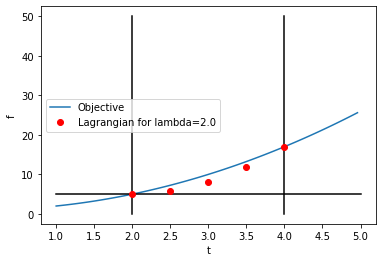

In [24]:
# Plot Lagrangian
t = np.arange(100)/100.*4+1
f = [i**2 + 1 for i in t]
plt.plot(t, f, label="Objective")

# plot feasible set
plt.plot([2, 2], [0, 50], color="black")
# plot feasible set
plt.plot([4, 4], [0, 50], color="black")
# plot optimal value
plt.plot([1, 5],[5, 5], color="black")

x_i = np.array([2.0, 2.5, 3.0, 3.5, 4.0])
lambda_i = 2.0
plt.plot(x_i, x_i**2 +1 + lambda_i* (x_i-2)*(x_i-4),'ro', label=f"Lagrangian for lambda={lambda_i}") 

plt.xlabel("t");
plt.ylabel("f");
plt.legend();

The dual problem is:

\begin{align}
\mathbf{maximize}&& -9 \lambda^2 / (1 + \lambda) +1 + 8\lambda\\
\mathbf{subject\, to}&& \lambda \ge 0
\end{align}

which is a convex otimization problem. The dual optimum occurs for $\lambda^* = 2$ with optimum value of $p^* = 5$. This confirms that strong duality holds.

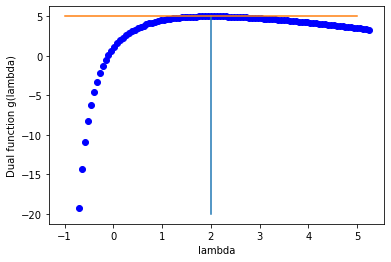

In [25]:
# plot dual function (inf L)
for lambda_i in np.arange(100)/100*6-0.7:
    plt.plot(lambda_i, -9*lambda_i**2/(lambda_i+1) + 8*lambda_i + 1,'bo')

plt.plot([2,2], [-20, 5])
plt.plot([-1, 5], [5,5])
plt.xlabel("lambda");
plt.ylabel("Dual function g(lambda)");

(d) Sensitivity analysis

The relaxed problem is given by:

\begin{align}
\mathbf{minimize}&& x^2 + 1\\
\mathbf{subject\, to}&& (x-2) (x-4) \le u
\end{align}

as a function of $u$. The constraint is infeasible for $u \ge < -1$. The feasible set is $[$3 - \sqrt{1+u},3+\sqrt{1+u}]$. For $u\ge 8$ the problem becomes basically unconstrained because the global minimum of the objective falls into the feasible interval. If $u \le 8$, the optimum $x^*$ is at the left limit of the feasible set (because the global minimum of the objective function is to the left of the feasible set. Together:

$
 p^*(u) =\begin{cases}
\begin{align}
               \infty && u \lt -1\\
               11 + u - 6 \sqrt(1+u) && -1 \le u \le 8\\
               1 && u \ge 8
            \end{align}
            \end{cases}
$


## Question 4: Option Price Bounds 

The problem to be solved as given in the example 5.10 of the textbook mentioned in the exercise

\begin{align}
\mathbf{minimize}&& p_n\\
\mathbf{subject\, to}&& V^T y = p \\
&& y \succcurlyeq 0
\end{align}

with prices at the beginning of the investment period $p_j$, $j=1, \dots, n$ and values at the end of the investment period of $v_j$, $j=1, \dots, n$ for assets $j$. There are $m$ possible outcome scenarios. The constraint ensures that there will be no arbitrage and is basd on Farkas' Lemma.

Side note to arbitrage: If there is an investment vector $x$ with $p^T x \le 0$ ($x_j < 0$ denotes a short position for asset $j$) and in all scenarios the value at the end of the investment period is nonnegative $v^{(i)T}x \ge 0$ then an arbitrage exists. This means there would be a guaranteed profit.

The optimization problem above yields the minimap price $p_n$ for asset $n$ for which the no arbitrage assumption is valid. Maximizing instead of minimizing would yield the maximum price consistent with the no arbitrage assumption.

In [26]:
# Asset prices of first six assets, the seventh is the price to be optimized
n_assets = 7  # Total number of assets is 7
S0 = 1  # Start price

p_collar = cvx.Variable()

p = np.array([
    1.0,   # risk free asset
    S0,   # S0 of the underlying asset
    0.06,  # given call option number 1
    0.03,  # given call option number 2
    0.02,  # given put option number 1
    0.01,  # given put option number 2
    p_collar,
])

In [29]:
# collar option payoff
m = 200  # Number of possible scenarios
S_min = 0.5  # Min end value for scenarios
S_max = 2.0  # Max end value for scenarios
S = np.linspace(S_min, S_max, m)  # Scenario values

F=0.9  # Floor
C=1.15  # Cap

collar_option_payoff = np.array(
    [
        (np.array([
            S-S0, np.repeat(F-S0, m)
        ])).max(axis=0),
        np.repeat(C, m) - S0]
).min(axis=0)

In [30]:
# Build complete payoff matrix
r = 1.05
V = np.zeros((m,n_assets))
V[:,0] = np.repeat(r, m) # risk free asset
V[:,1] = S  # underlying asset
V[:,2] = (S - 1.1).clip(0)  # given call option number 1
V[:,3] = (S - 1.2).clip(0)  # given call option number 2
V[:,4] = (-S + 0.8).clip(0)  # given put option number 1
V[:,5] = (-S + 0.7).clip(0)  # given put option number 2
V[:,6] = collar_option_payoff

In [21]:
# define additional optimization variable y
y = cvx.Variable(m)

In [26]:
# Define objective
obj_min = cvx.Minimize(p_collar)
obj_max = cvx.Maximize(p_collar)

In [27]:
# Define constraints
constraints = [
    cvx.vstack(p) - cvx.vstack(V.T @ y) == cvx.vstack(np.repeat(0.0, n_assets)),
    cvx.vstack(y) >= cvx.vstack(np.repeat(0.0, m))
]

In [28]:
# Form and solve problem
prob_min = cvx.Problem(obj_min, constraints)
prob_min.solve()# Returns the optimal value.
prob_max = cvx.Problem(obj_max, constraints)
prob_max.solve()# Returns the optimal value.
print("status:", prob_min.status, prob_max.status)
print("optimal value", prob_min.value, prob_max.value)

status: optimal optimal
optimal value 0.032619047619008155 0.06495039682537881
